In [ ]:
# melakukan komputasi numerik dan manipulasi array
import numpy as np
# memudahkan pengolahan data tabulas seperti df dan series
import pandas as pd
# menyimpan objek kedalam file untuk dapat digunakan kembali
import pickle

# melakukan visualisasi data statistik, seaborn memudahkan visualisasi karena lebih sederhana dibandingkan matplotlib
import seaborn as sns
# membuat visualisasu verbentuk awan kata dengan menampilkan ukuran yang proporsional terhadap krekuensi kemunculannya
from wordcloud import WordCloud
# membuat berbagai jenis plot dan grafik sehingga memberikan kontrol penuh atas detail visualisasi data
import matplotlib.pyplot as plt
# agar tidak membuat command show saat menjalankan library matplotlib dan akan dijalankan secara otomatis
%matplotlib inline

# NLTK merupakan lubrary untuk pemrosesan bahasa MLP yang menyediakan alat untuk koenisasi, stemming, lemmatization dan analisis teks
import nltk
# mengubah kata menjadi bentuk dasar
from nltk.stem import WordNetLemmatizer
# mengabaikan kata-kata umum
from nltk.corpus import stopwords
# membagi teks menjadi token
from nltk.tokenize import word_tokenize
# mengabaikan tanda baca
from string import punctuation

# membagi dataset menjadi data latih dan data uji
from sklearn.model_selection import train_test_split
# mengubah teks menjadi representasi numerik berdasarkan frekuensi kata
from sklearn.feature_extraction.text import TfidfVectorizer
# melakukan evaluasi kinerja model klasifikasi denfab menunjukkan jumlah prediksi yang benar dan salah
from sklearn.metrics import confusion_matrix, classification_report
# menghitung probabilitas berdasarkan fitur input
from sklearn.linear_model import LogisticRegression
# naive bayes digunakan untuk klasifikasi text
from sklearn.naive_bayes import MultinomialNB
# model klasifikaisi dengan pohon keputusab untuk meningkatkan akurasi dan mengurangi overfitting
from sklearn.ensemble import RandomForestClassifier
import re

In [ ]:
# mengimport modul warning untuk mengelola peringatan
import warnings
# menyembunykan peringatan yang biasa muncul saat menjalankan program, hal ini dilakukan untuk mengurangi gangguan saat menjalankan kode
warnings.filterwarnings('ignore')

# Exploratory Data Analysis (EDA)

In [ ]:
# import Grive kedalam GColab
from google.colab import drive
drive.mount('/content/drive')

# melakukan import dataset pada inventory
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cyberbullying_tweets.csv')
# menampilkan 5 sample dari dataframe
display(df.sample(5))
# menampilkan sample
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


tweet_text cyberbullying_type
6157   For topping your groups, you can now invite si...  not_cyberbullying
19026  Anyone who calls terrorists as militants is a ...           religion
10989  “@HuffingtonPost: Miley: "Everyone's a little ...             gender
8619   Wow, @TimCAD, a rape joke and a gay joke at th...             gender
20816  oh, u poor soul, u don't realise a flavour of ...           religion

(47692, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


Tidak ada missing value pada df

In [ ]:
# menampilkan kategori pada tipe cyberbullying
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

pada hasil program diatas dapat diketahui terdapat 6 kategori kelas yang ada dalam tipe cyberbulliying

In [ ]:
# Menampilkan jumlah tiap tweet pada semua kategori
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [ ]:
# menampilkan perhitungan statistik pada kolom bertipe data objek
df.describe()

tweet_text cyberbullying_type
count                                               47692              47692
unique                                              46017                  6
top     RT @sailorhg: the intro for my hardware hackin...           religion
freq                                                    2               7998

dari data diatas dapat dilihat terdapat jumlah tipe cyberbullying dengan bertipe religion dengan jumlah frequensi 7998

# VISUALISASI SEBELUM DILAKUKAN PRE-PROCESSING PADA DATA

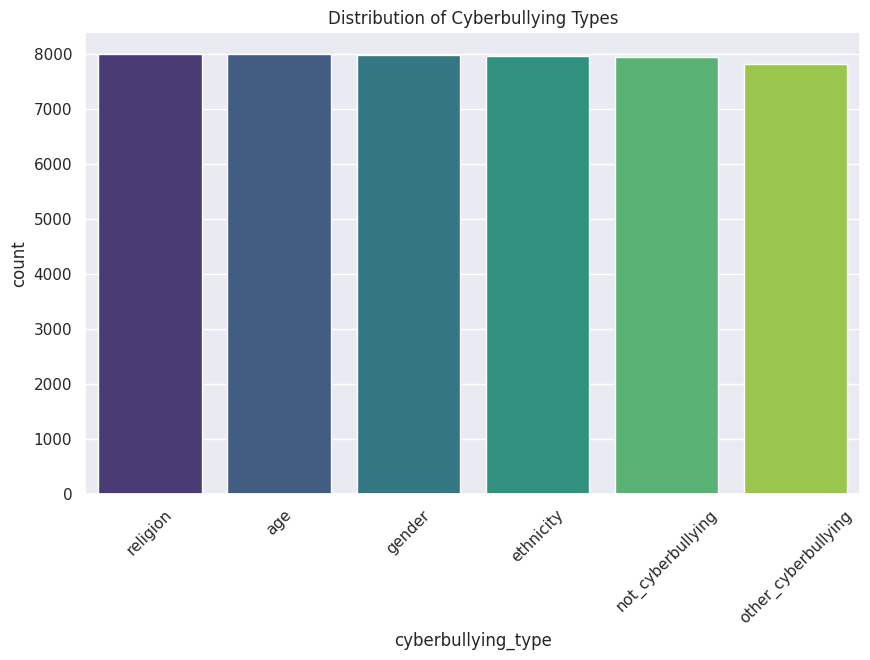

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cyberbullying_type', data=df, palette='viridis', order=df['cyberbullying_type'].value_counts().index)
plt.title('Distribution of Cyberbullying Types')
plt.xticks(rotation=45)
plt.show()

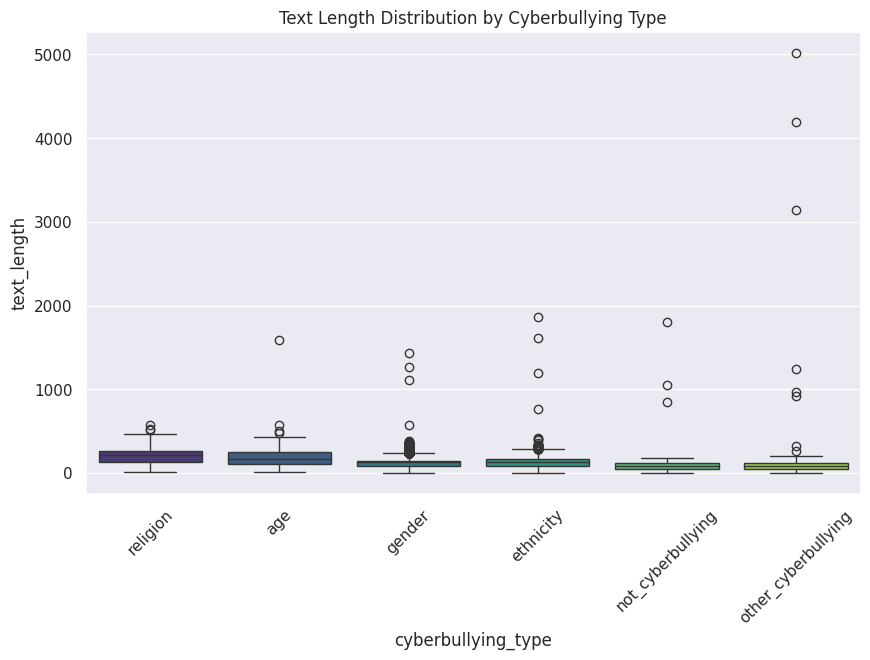

In [ ]:
df['text_length'] = df['tweet_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(x='cyberbullying_type', y='text_length', data=df, palette='viridis', order=df['cyberbullying_type'].value_counts().index)
plt.title('Text Length Distribution by Cyberbullying Type')
plt.xticks(rotation=45)
plt.show()

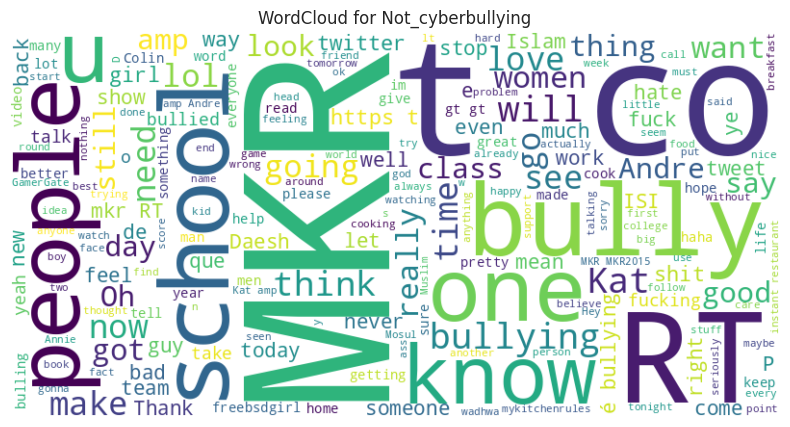

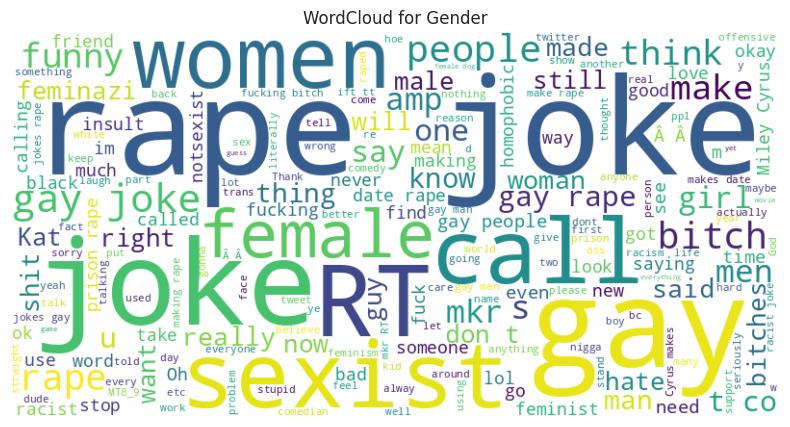

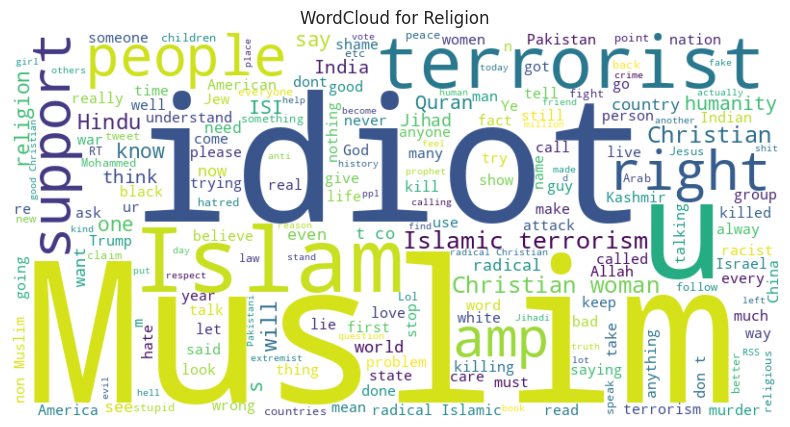

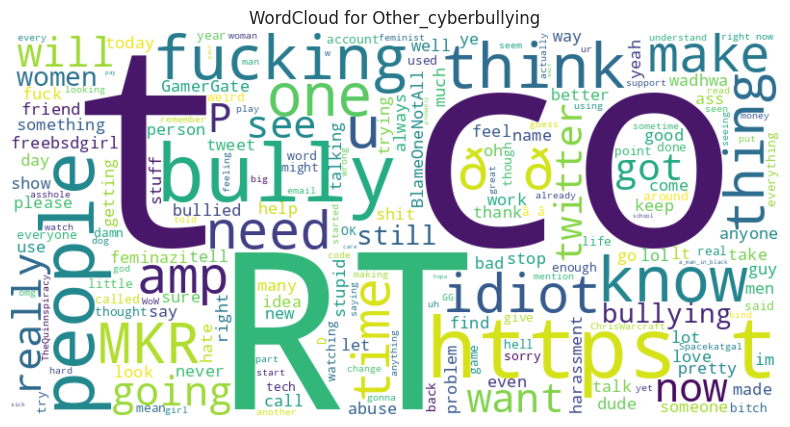

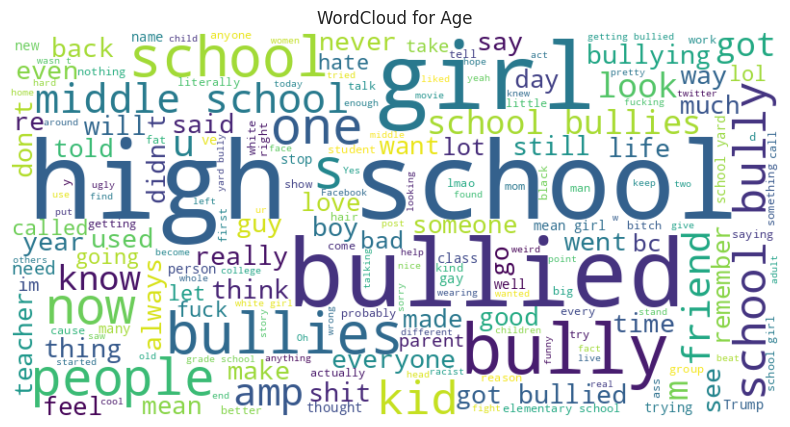

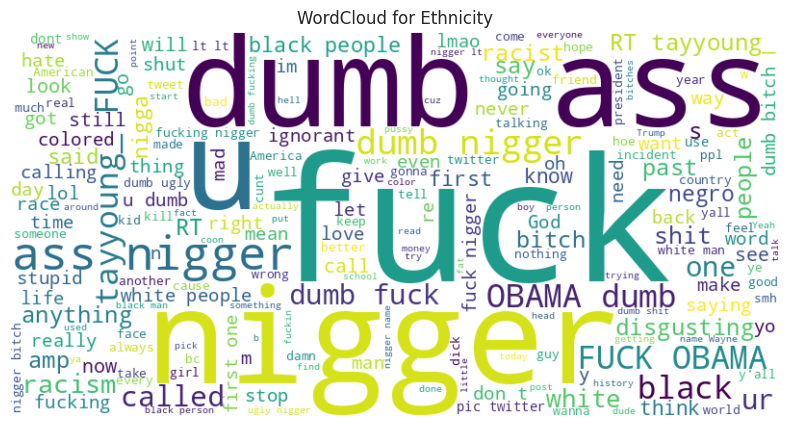

In [ ]:
for bullying_type in df['cyberbullying_type'].unique():
    text_data = " ".join(df[df['cyberbullying_type'] == bullying_type]['tweet_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {bullying_type.capitalize()}')
    plt.show()


# Data Pre-processing

tahap ini penting dilakukan untuk mempersiapkan data teks mentah yang akan digunakan dalam model, tujuan dari tahap ini untuk mengurangi adanya noise pada data set dan memastikan bahwa model dapat lebih efektif memahami dan menganalisis data teks

In [ ]:
# mengecek apakah terdapat data missing
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
text_length           0
dtype: int64

In [ ]:
# mengecek data duplikat dari kolom tweet_text
df['tweet_text'].duplicated().sum()

1675

dari hasil kode diatas dapat dilihat bahwa terdapat 1675 data yang memiliki duplikat dalam df

menghapus duplikat data pentung untuk membersikan data untuk menghasilkan analisis yang akurat, semakin banyak duplikat data dapat menyebabkan model menjadi overfitting

In [ ]:
# menghapus duplikasi data tanpa membuat salunan dan akan membuat df baru secara itmatis, index df yang dihasilkan berupa urutan yang benar agar data tidak berubah2 dan tetap konsisten meskipun telah menghapus duplikat data
df.drop_duplicates('tweet_text', inplace=True, ignore_index=True)
# menampilkan jumlah dataset setelah menghapus duplikat data
df['tweet_text'].duplicated().sum()

0

In [ ]:
# menampilkan Jumlah value berdasarkan tipe cyberbullying
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64

In [ ]:
# mendefiniskan tipe cyberbullying yang akan diencoding
cyberbullying_type = ['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity', 'other_cyberbullying']
# membuat dictionary tipe cyberbullying
encoding_dict = {'not_cyberbullying':0, 'gender':1, 'religion':2, 'age':3, 'ethnicity':4, 'other_cyberbullying':5}
# mengganti nilai-nilai dalam tipe cyberbullying menjadi nilai dalam encoding_dict
df['cyberbullying_type'] = df['cyberbullying_type'].map(encoding_dict)
# menampilkan 6 sample pada df setelah dilakukan encoding
df.sample(6)

tweet_text  cyberbullying_type  \
3280                     That's karma Kat and Andre #mkr                   0   
15942  Islam considers women as one big sex organ, so...                   2   
18715  @pravingandhino1 stop expressing ur level of i...                   2   
3793   Rhett S. Daniels, litigious bully http://t.co/...                   0   
45114  Like I said, it was the tip of the iceberg. I ...                   4   
38886  @caroranwill: “My body and blood are a tangibl...                   4   

       text_length  
3280            31  
15942          135  
18715          144  
3793            53  
45114          279  
38886          264

## NLP Processing

dilakukan untuk memungkinkan komputer memahami, memproses, dan menghasilkan bahasa manusia secara efektif.

In [ ]:
# Downloading dependencies
# mendownload library untuk mengabaikan informasi yang tidak penting dan membersikan kata-kata umum
nltk.download('stopwords')
# melakukan tokenisasi untuk mengubah kalimat menjadi kata-kata
nltk.download('punkt')
# menghubungkan kata-kata berdasarkan sinomin, antonim dan relasi lainnya untuk melakukan lemmatization untuk mengubah kalimat menjadi kata dasarnya
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

mengunduh library diatas dapat memberikan akses untuk menggunakan tools NLP untuk membantu pemprosesan bahasa secara alami seperti tokenisasi teks, pembersihan data dan lemmatization.

In [ ]:
stopwords_list = stopwords.words('english')
additional_stopwords = ['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's']
stopwords_list.extend(additional_stopwords)
lemmatizer = WordNetLemmatizer()

# menghapus username tweet
def remove_usernames(tweet):
  # menghapus spasi awal dan akhir string lalu membagi string menjadi daftar kata
    words = tweet.strip().split()
    # membuat daftar baru untuk kata-kata yang tidak dimulai dengan '@'
    words = [word for word in words if word[0]!='@']
    # menggabungkan kata-kata yang tersisa menjadi sting dengan spasi sebagai pemisah
    return ' '.join(words)

# menghapus hashtags
def remove_hashtags(tweet):
    # menghapus spasi awal dan akhir string lalu membagi string menjadi daftar kata
    words = tweet.strip().split()
    # membuat daftar baru yang berisi kata-kata yang tidak dimulai dengan '#' (hashtag)
    words = [word for word in words if word[0]!='#']
    # menembalikan nilai dengan spasi sebagai pembatas
    return ' '.join(words)

# menghapus link
def remove_links(tweet):
    # menghapus spasi awal dan akhir string lalu membagi string menjadi daftar kata
    words = tweet.strip().split()
    # membuat daftar baru berisi kata yang tidak diawali 'http'
    words = [word for word in words if word[:4]!='http']
    # mengembalikan nilai dengan spasi sebagai pembatas
    return ' '.join(words)

# menghapus tanda baca
def remove_punctuation(tweet):
    # membuat perulangan yang berisi tanda baca
    for mark in punctuation:
        # menghapus tanda baca dari tweet
        tweet = tweet.replace(mark, '')
    # mengembalikan nilai tweet setelah menghapus tanda baca
    return tweet

# mengkonversi kata menjadi huruf kecil
def convert_lowercase(tweet):
  # mengembalikan data tweet menjadi huruf kecil
    return tweet.lower()

# melakukan tokenisasi
def tokenization(tweet):
    # melakukan tokenisasi pada tweet
    return word_tokenize(tweet)

# menghapus stopword (kata tidak penting)
def remove_stopwords(tok_tweet):
    # membuat daftar baru untuk menyimpan kata-kata yang bukan stopwords
    test = []
    # membuat perulangan untuk tiap kata dalam daftar token
    for word in tok_tweet:
        # membuat kondisi jika kata bukan dalam daftar stopwords
        if word not in stopwords_list:
            # menambahkan kedalam list
            test.append(word)
    # mengembalikan nilai test yang telah terisi
    return test

# melakukan lemmatization
def lemmatize_words(tok_tweet):
  # membuat list kosong untuk kata yang telah dilakukan lemmatization
    test = []
    # membuat perulangan dalam daftar token
    for word in tok_tweet:
        # menambahkan kata yang telah dilemmatization dengan fungsi lemmatize pada library
        test.append(lemmatizer.lemmatize(word))
    # mengembalikan nilai yang telah dilakan lemmatization ( bentuk dasar )
    return test

In [ ]:
# membuat variabel berisi hasil pembersihan data dengan nama variabel clean stwwt
def pre_processing_custom(tweet):
    tweet = remove_usernames(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_links(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    # menggunakan tok_tweer untuk melakukan pemprosesan kalimat dalam bentuk token (terpisah menjadi kata)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_df = ' '.join(tok_tweet)

    return clean_df

In [ ]:
# membuat df berisi df setelah dilakukan preprocessing dan menampilkan kalimat setelah dilakukan pembersihan
df['clean_tweets'] = df['tweet_text'].map(pre_processing_custom)
df.sample(6)

tweet_text  cyberbullying_type  \
23413  U will never get such enlightenment in life un...                   2   
34044  Imagine basing your fashion choices on what ev...                   3   
969    @AdamJDT Yeah it's hilarious how women's contr...                   0   
39662  That shit is annoying and I don't even post th...                   4   
21652  #Hinduphobia_in_Arab U hv religious sharia law...                   2   
787    There's a cave nearby where Colin keeps his st...                   0   

       text_length                                       clean_tweets  
23413          176  never get enlightenment life unless undergo ma...  
34044          248  imagine basing fashion choice everyone else we...  
969            119  yeah hilarious woman contribution science mini...  
39662          276  shit annoying dont even post thirst trap ever ...  
21652          274  hv religious sharia law give religious freedom...  
787             54                 there cave nearby colin keep stuff

In [ ]:
# membersikan test tweet dengan library tweer-preprocessing  dengan tweet sebagai parameter
def clean_tweets(tweet):
    # mengapus elemen seperti URL, Mention, Hastag, Emoji dan tanda baca
    tweet = p.clean(tweet)
    # mengembalikan data setelah dilakukan preprocessing
    return tweet

In [ ]:
# hasil pembersihan data dimasukkan dalam variabel clean_tweets
def pre_processing(tweet):
    tweet = clean_tweets(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_df = ' '.join(tok_tweet)

    return clean_df

In [ ]:
!pip install tweet-preprocessor
import preprocessor as p

In [ ]:
# membuat df berisi hasil sebelum dan sesudah dilakukan pembersihan data
df['clean_tweets'] = df['tweet_text'].map(pre_processing)
df['clean_tweets'].sample(5)

16292                     according islamic terrorism myth
16176    peaceful blm radical marxist broke thru locked...
43805                          k fuck obama dumb as nigger
23395    read following book start throwing expert comm...
37299    lasting second liverpool school astros taken b...
Name: clean_tweets, dtype: object

In [ ]:
# memeriksa apakah terdapat duplikasi pada data yang telah dilakukan pembersihan
df['clean_tweets'].duplicated().sum()

1757

In [ ]:
# menghapus data duplikat
df.drop_duplicates('clean_tweets', inplace=True, ignore_index=True)
df['clean_tweets'].duplicated().sum()

0

In [ ]:
# menampilkan dimensi setelah dilakukan pembersihan data
df.shape

(44260, 4)

In [ ]:
# menghitung jumlah kata pada data
df['word_count'] = df['tweet_text'].map(lambda x: len(x.split()))
df.sample(5)

tweet_text  cyberbullying_type  \
7243   @carlosfaboayuso c te hace conocida esa histor...                   0   
22662  @dancohen3000 @MaxBlumenthal Wheras the Arabs ...                   2   
6965   @SirajZarook @BilalIGhumman @OdiniaInvictus @I...                   0   
14785  Your mother and every single female in your li...                   1   
36318  Classic "put down" from Cameron! Basically a s...                   3   

       text_length                                       clean_tweets  \
7243           127  c te hace conocida esa history en yuctan se ll...   
22662          102   wheras arab really behaving people scum ignoring   
6965           132                             think thing meaningful   
14785          256  mother every single female life ought ashamed ...   
36318          174  classic put cameron basically school yard bull...   

       word_count  
7243           22  
22662          15  
6965           14  
14785          51  
36318          30

In [ ]:
# menghitung rata-rata jumlah kata
def avg_word_length(tweet):
    # melakukan tokenisasi pada tweet
    words = tweet.split()
    # menghitung jumlah kata
    word_count = len(words)
    # menyimpan total jumlah karakter semua kata
    word_length = 0
    # membuat perulangan untuk setiap kata
    for word in words:
        # menghitung jumlah karakter
        word_length += len(word)
    # menghitung rata-rata panjang kata dengan membagi total panjang karakter dengan jumlah kata
    avg_length = round(word_length / word_count,2)
    # mengembalikan nilai hasil rata-rata
    return avg_length

# menampilkan hasil jumlah panjang data dan rata-rata jumlah kata
df['avg_word_length'] = df['tweet_text'].map(avg_word_length)
df.sample(5)


tweet_text  cyberbullying_type  \
1657           #mkr” Fuck &amp; shit would be my choice.                   0   
158    this has been the longest most uneventful week...                   0   
17219  @buttercupashby @MaDaSaHaTtEr_17 Mohammed was ...                   2   
24851  @cheeseplus &lt;3 &lt;3 &lt;3 srsly tho, power...                   5   
35126  Apparently pretty girls get bullied throughout...                   3   

       text_length                                       clean_tweets  \
1657            41                         fuck amp shit would choice   
158            108  longest uneventful weekend life feel like came...   
17219          104        mohammed murderer people killed disagreeing   
24851          108  lt3 lt3 lt3 srsly tho powering massive redis d...   
35126           84  apparently pretty girl get bullied throughout ...   

       word_count  avg_word_length  
1657            8             4.25  
158            21             4.19  
17219          14             6.50  
24851          19             4.74  
35126          13             5.54

hasil perhitungan rata-rata panjang katra dapat digunakan untuk mengindentifikasi pola dan membantu dalam melakukan analisis teks dan pemprosesan bahasa dalam NLP

In [ ]:
# menghapus baris dengan jumlah kurang dari 3 kata
df = df[df['word_count']>3]
# menghapus baris dengan jumlah lebih dari 100 kata
df = df[df['word_count']<100]
# melakukan reset indeks setelah dilakukan filter data
df.reset_index(drop=True, inplace=True)
# menampilkan dimensi setelah dataframe dilakukan filter
df.shape

(43693, 6)

proses diatas penting untuk dilakukan untuk mengambil data yang berisi informasi yang benar-benar hanya dibutuhkan, dengan jumlah kata kurang dari 3 maka tidak akan memberikan informasi yang jelas dan akan menjadi bias. sedangkan kalimat diatas 100 akan membuat data menjadi kompleks karena jumlah kata yang terlalu banyak

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

ModuleNotFoundError: No module named 'vaderSentiment'

# VISUALISASI SETELAH DILAKUKAN PRE-PROCESSING PADA DATA

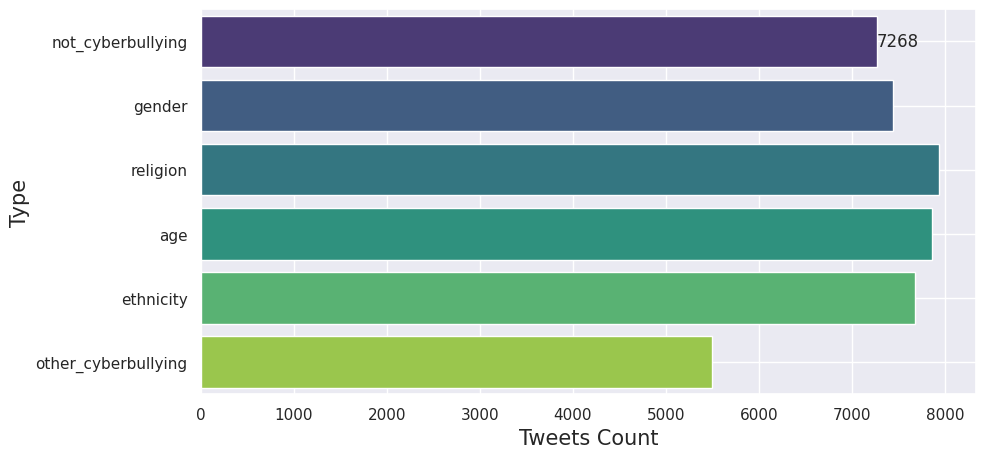

In [ ]:
# mengatur tema seaborn
sns.set_theme()
plt.figure(figsize=(10, 5))
# mengatur sumbu x dan sumbu y untuk count plot dalam df
ax = sns.countplot(data=df, y='cyberbullying_type', palette="viridis")
# mengatur label
ax.bar_label(ax.containers[0])
# menetapkan sumbu x dan sumbu y dengan ticks berupa jumlah kategori dalam cyberbullying
plt.yticks(ticks=[0,1,2,3,4,5], labels=cyberbullying_type)
# mengatur label sumbu x
plt.xlabel('Tweets Count', size=15)
# mengatur labrel sumbu y
plt.ylabel('Type', size=15)
# mengatur warna kolom
plt.grid(color='w')

dari diagram diatas dapat disimpulkan bahwa jumlah tiap kategori memiliki nilai yang hampir sama jumlahnya

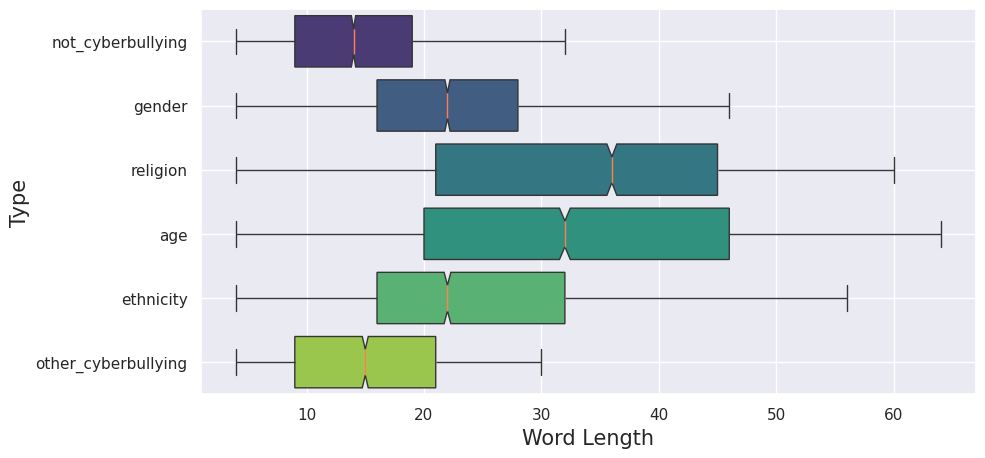

In [ ]:
# menetapkan ukuran figure dengan menentukan ukuran area gambar untuk plot yang akan dibuat
plt.figure(figsize=(10, 5))
# membuat diagram boxplot
sns.boxplot(data=df, y='cyberbullying_type', x='word_count', orient='h', showfliers=False, palette='viridis', notch=True, medianprops={"color": "coral"})
# membuat label untuk tiap kategori
plt.yticks(ticks=[0,1,2,3,4,5], labels=cyberbullying_type)
# mengatur label sumbu x
plt.xlabel('Word Length', size=15)
# membuat label sumbu y
plt.ylabel('Type', size=15)
# membuat warna grid
plt.grid(color='w')

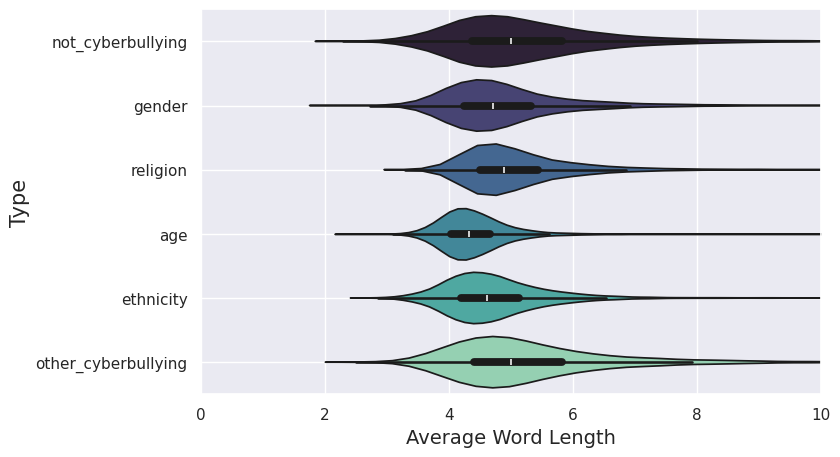

In [ ]:
# mengatur ukuran diagram
plt.figure(figsize=(8, 5))
# menampilkan violin plot
sns.violinplot(data=df, y='cyberbullying_type', x='avg_word_length', orient='h', palette='mako')
# menentukan sumbu x
plt.xlim(0, 10)
# menentukan sumbu y
plt.yticks(ticks=[0,1,2,3,4,5], labels=cyberbullying_type)
# mengatur label sumbu x
plt.xlabel('Average Word Length', size=14)
# mengatur sumbu y
plt.ylabel('Type', size=15)
# mengatur warna
plt.grid(color='w')

Text(32.0, 0.5, 'Average Word Length')

<Figure size 800x500 with 0 Axes>

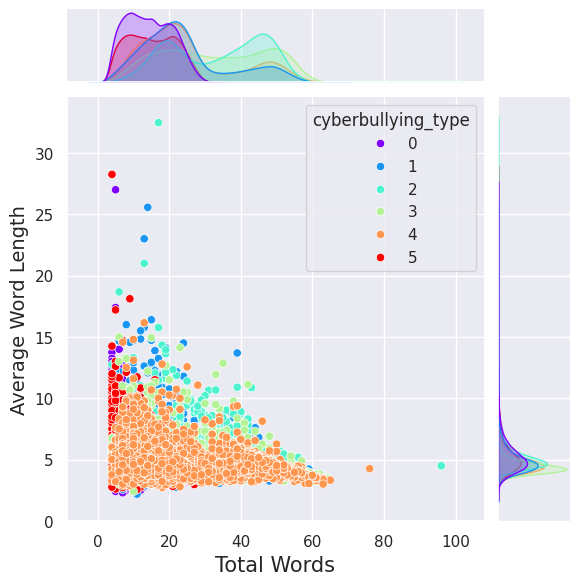

In [ ]:
# mengatur ukuran diagram
plt.figure(figsize=(8, 5))
# membuat joint ploy
sns.jointplot(data=df, y='avg_word_length', x='word_count', hue='cyberbullying_type', palette='rainbow')
# mengatur label sumbu x
plt.xlabel('Total Words', size=15)
# mengatur label sumbu y
plt.ylabel('Average Word Length', size=14)

dari diagram diatas dapat dilihat terdapat beberapa data outliers

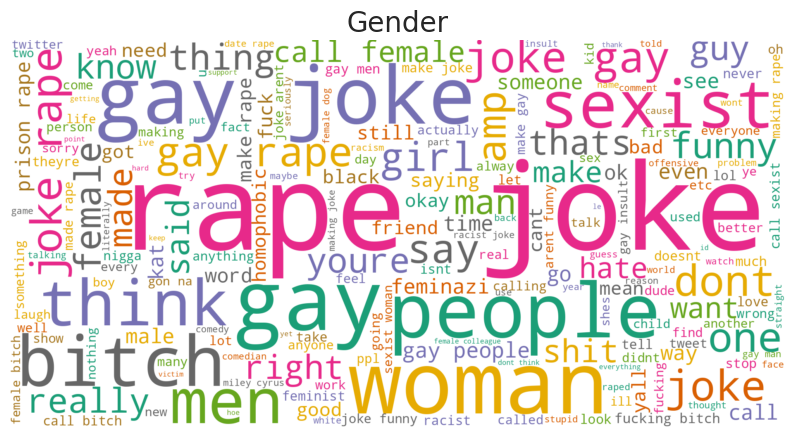

In [ ]:
# membuat Word cloud pada kategori gender
plt.figure(figsize=(10, 10))
# subset data yang akan digunakan
subset1 = df[df['cyberbullying_type']==1]
# membuat text untuk word cloud
text_gender = subset1['clean_tweets'].values
# membuat word cloud
wc1 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_gender))

# menghilangkan sumbu pada plot
plt.axis('off')
# membuat tittle
plt.title("Gender", fontsize=20)
# menampilkan word cloud sebagai gambar
plt.imshow(wc1, interpolation='bilinear')

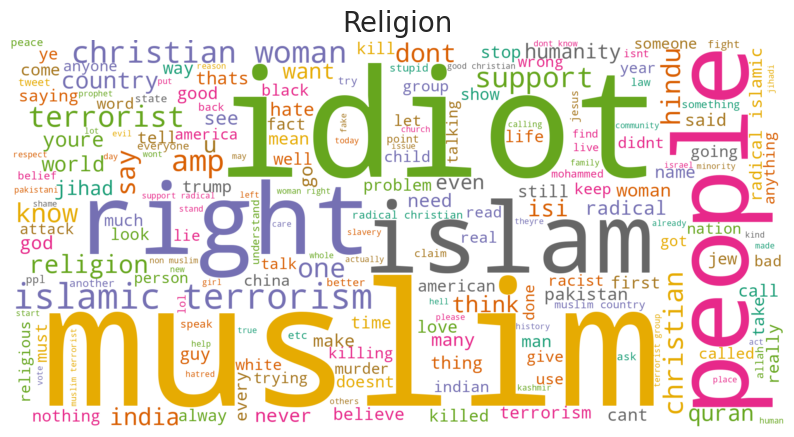

In [ ]:
# membuat word cloud untuk kategori religion
plt.figure(figsize=(10, 10))
subset2 = df[df['cyberbullying_type']==2]
text_religion = subset2['clean_tweets'].values
wc2 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_religion))

plt.axis('off')
plt.title("Religion", fontsize=20)
plt.imshow(wc2, interpolation='bilinear')

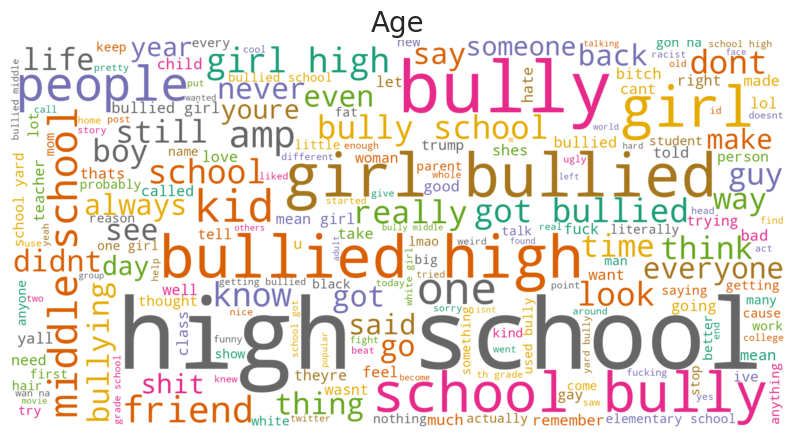

In [ ]:
# membuat word cloud untuk kategori age
plt.figure(figsize=(10, 10))
subset3 = df[df['cyberbullying_type']==3]
text_age = subset3['clean_tweets'].values
wc3 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_age))

plt.axis('off')
plt.title("Age", fontsize=20)
plt.imshow(wc3, interpolation='bilinear')

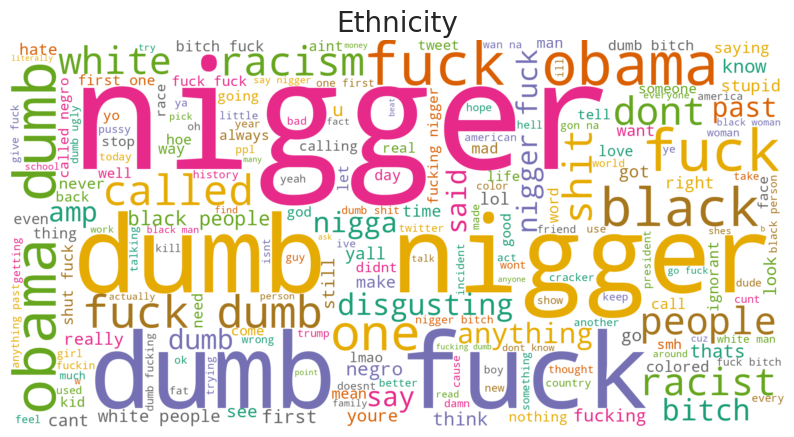

In [ ]:
# membuat word cloud untuk kategori ethnicity
plt.figure(figsize=(10, 10))
subset4 = df[df['cyberbullying_type']==4]
text_ethnicity = subset4['clean_tweets'].values
wc4 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_ethnicity))

plt.axis('off')
plt.title("Ethnicity", fontsize=20)
plt.imshow(wc4, interpolation='bilinear')

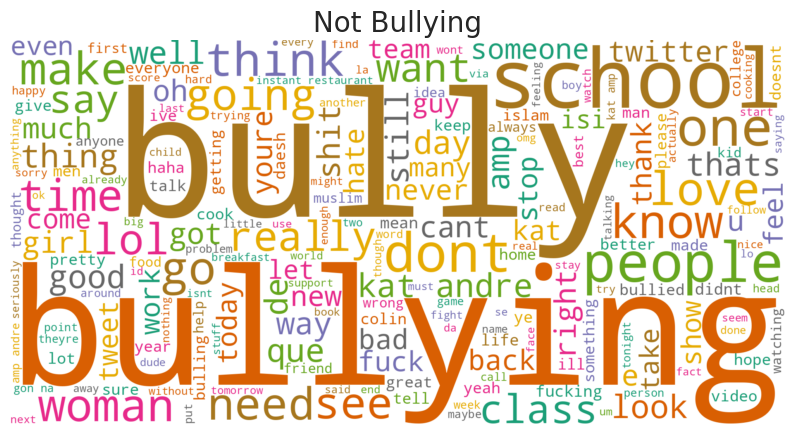

In [ ]:
# membuat word cloud untuk kategori not bullying
plt.figure(figsize=(10, 10))
subset0 = df[df['cyberbullying_type']==0]
text_not = subset0['clean_tweets'].values
wc0 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_not))

plt.axis('off')
plt.title("Not Bullying", fontsize=20)
plt.imshow(wc0, interpolation='bilinear')

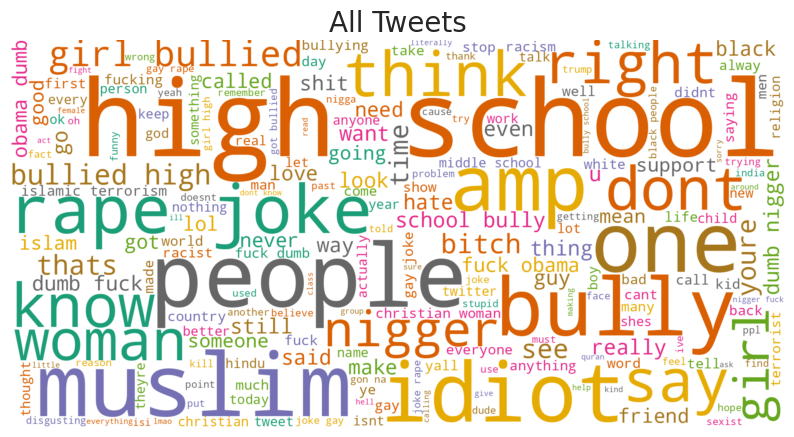

In [ ]:
# menampilkan semua kategori pada word cloud
plt.figure(figsize=(10, 10))
text_all = df['clean_tweets'].values
wc = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_all))

plt.axis('off')
plt.title("All Tweets", fontsize=20)
plt.imshow(wc, interpolation='bilinear')

In [ ]:
# mengimport library counter untuk menghitung frekuensi elemen dalam iterable seperti daftar
from collections import Counter
# membuat list kosong untuk mnenyimpan semua kata yang telah di lakukan preprocessing
temp=[]
# membuat perulangan untuk setiap tweet tweet yng telah dibersihkan dalam df
for tweet in df['clean_tweets']:
  # membagi tweet menjadi kata
  for word in tweet.split():
    # menambahkan kata ke list
    temp.append(word)
# menghitung frekuensi kata yang muncul dalam list
vocab = Counter(temp)
# menampilkan jumlah vocab yang muncul
print("Vocabulary Size:", len(vocab))
# menampilkan jumlah frekuensi kata terbanyak
print(list(vocab.items())[:6])

Vocabulary Size: 40523
[('word', 925), ('food', 143), ('crapilicious', 1), ('white', 2248), ('classy', 35), ('whore', 80)]


In [ ]:
# membuat perulangan untuk menyimpan jumlah kata yang paling sering muncul sebanyak 10 kata
common_word=[]
freq=[]
# i sebagai kata dan j sebagai frekuensi kata tersebut muncul
for i, j in vocab.most_common()[:10]:
  common_word.append(i)
  freq.append(j)

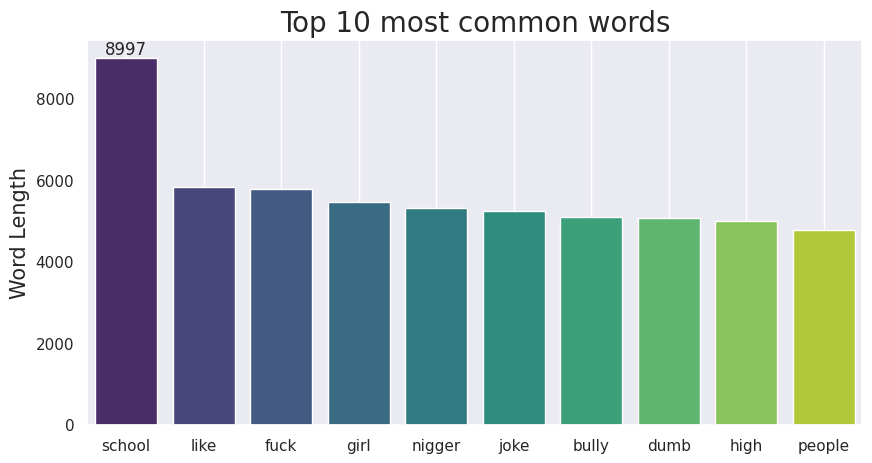

In [ ]:
# menampilkan hasil loop kedalam barplot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=common_word, y=freq, palette='viridis')
plt.title('Top 10 most common words', size=20)
ax.bar_label(ax.containers[0])
plt.ylabel("Word Length", size=15)
plt.grid()

In [ ]:
#membuat data train dan data set berdasarakan kolom kategori cyberbullying dengan x sebagai data dan y sebagai label
X = df['clean_tweets']
y = df['cyberbullying_type']
# membagi data menjadi data latih dan data uji dengan proporsi 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=76)

melakukan evlauasi kinerja model, data uji dilakukan untuk menunjukkan apakah model yang dibangun bekerja dengan baik diluar data latih, membagi 80% data latih dan 20 % data uji memastikan bahwa model telah dievaluasi dengan adil dan dapat merepresentasikan model dengan baik

# TF-IDF Vectorization

dilakukan untuk pemprosesan data untuk menilai seberapa penting sebuah kata dalam dokumen relatif terhadap kumpulan dokumen, teknik ini sering digunakan dalam analisis teks

In [ ]:
# mengubah fitur numerik berbasis tf-idf
tfidf = TfidfVectorizer(ngram_range=(1,2))
# melatih data train
tfidf.fit(X_train)
# menampilkan jumlah fitur yang dihasilkan
print("No. of feature words:", len(tfidf.get_feature_names_out()))

No. of feature words: 313297


In [ ]:
# mengubah data train dan data test menjadi tf-idf
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)
print(f"{X_train_tf.shape = }\n{X_test_tf.shape = }")

X_train_tf.shape = (34954, 313297)
X_test_tf.shape = (8739, 313297)


# Logistic Regression
merupakan model dalam machine learning yang sering digunakan untuk klasifikasi, model ini cukup sederhana sehingga sangat populer digunakan untuk mengolah data.

model ini akan memprediksi probabilitas letak kelas atau cluster sebuah data.

In [ ]:
# Melatih model menggunakan regresi logistik dengan data yang diubah menjadi vector Solver 'saga' dan regularisasi L2 digunakan untuk memastikan model dapat menangani dataset besar dengan baik dan mencegah overfitting.
lr = LogisticRegression(solver='saga', penalty='l2', random_state=394)
# melatih model yang telah ditransformasi menjadi vector
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=394, solver='saga')

In [ ]:
# melihat seberapa baik model dapat melakukan prediksi label pada data train
y_pred_train = lr.predict(X_train_tf)
# melihat seberapa baik model dapat melakukan prediksi label pada data train
y_pred_test = lr.predict(X_test_tf)

In [ ]:
# melihat hasil akurasi dari model
print('Logistic Regression train\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\Logistic Regression test\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

dari hasil diatas dapat disimpulkan bahwa data train memiliki akurasi yang cukup tinggi dengan nilai akurasi sebesar 96%

sedangkan nilai data test memiliki besar akurasi sebanyak 92%

Selisih yang kecil antara akurasi data train (96%) dan akurasi data test (92%) menunjukkan bahwa model tidak mengalami overfitting yang signifikan

dari akurasi tersebut dapat disimpulkan bahwa model telah melakukan generalisasi dengan baik dan mampu menangani variasi data dengan baik.

dengan akurasi yang mencapai 92% dapat diimplementasikan sebagai model dan mentolerir tingkat kesalahan sebesar 8%

Text(0.5, 1.0, 'Confusion Matrix LR')

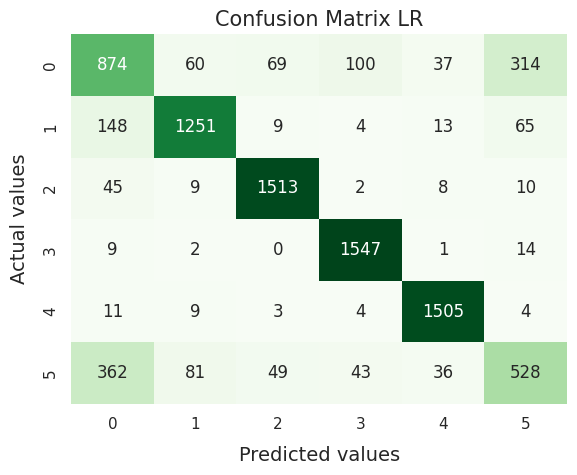

In [ ]:
# Membuat visualisasi confusionmatrix
# matrix ini memberikan gambaran visual kinerja model dalam memprediksi kelas
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix LR', size=15)

# Naive-Bayes

model ini berfungsi untuk klasifikasi text dengan mengansumsikan bahwa fitur-fitur bersidat independen satu sama lain. kelebihan metode ini sangat cepat untuk dilatih dan digunakan bahkan untuk dataset yang berukuran besar.

In [ ]:
# Melakukan model training
mnb = MultinomialNB(alpha=0.1)
# menyesuaikan model dengan data train
mnb.fit(X_train_tf, y_train)

MultinomialNB(alpha=0.1)

alpha 0.1 merupakan parameter untuk menangani apabila terdapat masalah seperti nilai probabilitas 0, dengan ini akan mengurangi adanya variabilitas dan meningkatkan generalisasi model

In [ ]:
# Melakukan model prediction
y_pred_train = mnb.predict(X_train_tf)
y_pred_test = mnb.predict(X_test_tf)

In [ ]:
# Melakukan evaluasi pada model
print('\tClassification Report for Naive-Bayes\' on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Naive-Bayes\' on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Naive-Bayes' on Train

                      precision    recall  f1-score   support

  not_cyberbullying       0.99      0.97      0.98      5814
             gender       0.99      0.99      0.99      5958
           religion       0.99      1.00      0.99      6350
                age       0.98      1.00      0.99      6292
          ethnicity       0.99      1.00      0.99      6145
other_cyberbullying       1.00      0.96      0.98      4395

           accuracy                           0.99     34954
          macro avg       0.99      0.99      0.99     34954
       weighted avg       0.99      0.99      0.99     34954


	Classification Report for Naive-Bayes' on Test

                      precision    recall  f1-score   support

  not_cyberbullying       0.66      0.42      0.51      1454
             gender       0.81      0.83      0.82      1490
           religion       0.79      0.97      0.87      1587
                age       0.72      0.98

berdasarkan hasil evaluasi dapat dilihat jumlah akurasi model pada data train sebesar 99% namun pada data set hanya 85% saja.

penurunan signifikan pada data uji menunjukkan bahwa model ini kemungkinan mengalami adanya overfitting, dan tidak dapat melakukan generalisasi dengan baik

Text(0.5, 1.0, 'Confusion Matrix NB')

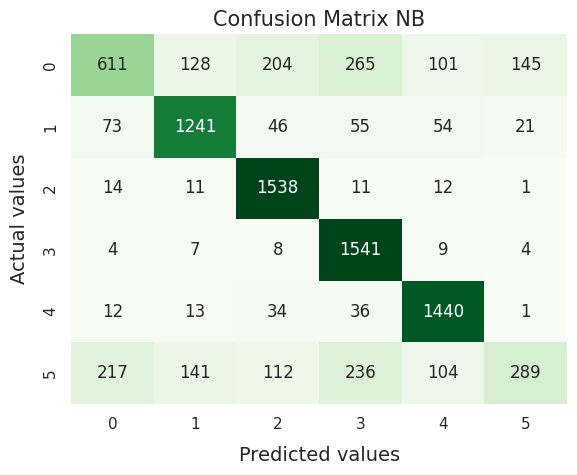

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix NB', size=15)

# Random Forest

In [ ]:
# Model training
rf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=30, random_state=27)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(criterion='entropy', max_depth=30, random_state=27)

jumlah 100 pohon keputusan sering digunakan sebagai nilai default. dan merupakan nilai yang pas karena tidak terlalu banyak dan juga tidak terlalu sedikit

memilih Entropy karena sering digunakan dalam aplikasi seperti klasifikasi teks dan masalah klasifikasi multikategori

agar mencegah kompleksitas model sehingga kedalaman maksimum pohon keputusan cukup 30 saja

In [ ]:
# Model prediction
y_pred_train = rf.predict(X_train_tf)
y_pred_test = rf.predict(X_test_tf)

In [ ]:
# Model evaluation
print('\tClassification Report for Random Forest on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Random Forest on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Random Forest on Train

                      precision    recall  f1-score   support

  not_cyberbullying       0.51      0.89      0.65      5814
             gender       0.93      0.78      0.85      5958
           religion       0.91      0.97      0.94      6350
                age       0.92      0.98      0.95      6292
          ethnicity       0.95      0.98      0.96      6145
other_cyberbullying       1.00      0.01      0.01      4395

           accuracy                           0.81     34954
          macro avg       0.87      0.77      0.73     34954
       weighted avg       0.87      0.81      0.77     34954


	Classification Report for Random Forest on Test

                      precision    recall  f1-score   support

  not_cyberbullying       0.50      0.83      0.62      1454
             gender       0.90      0.76      0.82      1490
           religion       0.89      0.96      0.92      1587
                age       0.90      0.

Text(0.5, 1.0, 'Confusion Matrix RF')

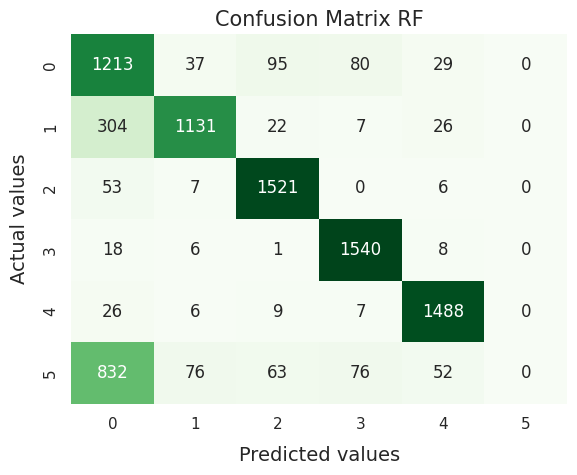

In [ ]:
# Confusion Matrix for Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix RF', size=15)

In [ ]:
# Model Training
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators = [('lr', lr), ('mnb', mnb), ('rf', rf)], voting='soft')
vot.fit(X_train_tf, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=394,
                                                 solver='saga')),
                             ('mnb', MultinomialNB(alpha=0.1)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=30,
                                                     random_state=27))],
                 voting='soft')

In [ ]:
# Model prediction
y_pred_train = vot.predict(X_train_tf)
y_pred_test = vot.predict(X_test_tf)

In [ ]:
# Model evaluation
print('\tClassification Report for Voting on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Voting on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Voting on Train

                      precision    recall  f1-score   support

  not_cyberbullying       0.99      0.97      0.98      5814
             gender       0.99      0.99      0.99      5958
           religion       0.99      1.00      0.99      6350
                age       0.98      1.00      0.99      6292
          ethnicity       0.99      1.00      1.00      6145
other_cyberbullying       0.99      0.96      0.98      4395

           accuracy                           0.99     34954
          macro avg       0.99      0.99      0.99     34954
       weighted avg       0.99      0.99      0.99     34954


	Classification Report for Voting on Test

                      precision    recall  f1-score   support

  not_cyberbullying       0.63      0.57      0.60      1454
             gender       0.86      0.86      0.86      1490
           religion       0.86      0.98      0.92      1587
                age       0.84      0.99      0.91  

berdasarkan hasil evaluasi dapat dilihat jumlah akurasi model pada data train sebesar 99% dan data test sebesar 91%

model ini memiliki akurasi yang lebih tinggi pada data train namun terdapat penurunan pada data test yang mengindikasikan adanya kemungkinan overfitting


Text(0.5, 1.0, 'Confusion Matrix Voting')

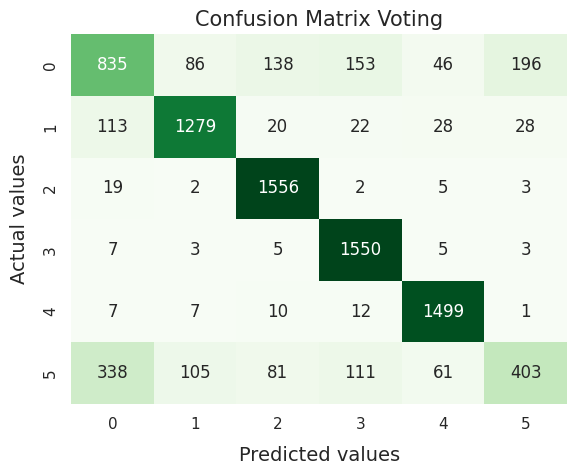

In [ ]:
# Confusion Matrix after Voting
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix Voting', size=15)

Berdasarkan hasil analisis logistic regression merupakan model terbaik yang dapat digunakan karena memiliki akurasi yang tinggi dan paling sedikit selisih penurunan nilai akurasi dari data train ke data test.

In [ ]:
# menyimpan model dengan pickle sehingga file pickle dapat diguanakn kembali tanpa harus melakukan train data kembali
model_file = open('LogisticRegression.pickle','wb')
pickle.dump(lr, model_file)
model_file.close()

model_file = open('NaiveBayes.pickle','wb')
pickle.dump(mnb, model_file)
model_file.close()

model_file = open('RandomForest.pickle','wb')
pickle.dump(rf, model_file)
model_file.close()

model_file = open('Voting.pickle','wb')
pickle.dump(vot, model_file)
model_file.close()

In [ ]:
# membuat prediksi terhadap text baru dengan model yang telah dilatih sebelumnya
def predict(model, texts):
    clean_texts = [pre_processing_custom(text) for text in texts]
    text_data = tfidf.transform(clean_texts)
    prediction = model.predict(text_data)

    data = []
    for text, prediction in zip(texts, prediction):
        data.append((text, prediction))

    df = pd.DataFrame(data, columns = ['text','type'])
    df = df.replace([0,1,2,3,4,5], cyberbullying_type)
    return df

In [ ]:

model_file = open('Voting.pickle', 'rb')
model = pickle.load(model_file)
model_file.close()

text                 type
0   You're a girl, you can't possibly understand a...               gender
1    Men like you are always so aggressive and toxic.               gender
2   Women like you should stay in the kitchen, not...               gender
3   No one listens to a guy who is that emotional,...             religion
4   People from your faith are always causing prob...             religion
5   You're just brainwashed by your religious beli...             religion
6   No wonder you act like that, your religion tea...             religion
7     You're just a kid, your opinion doesn't matter.             religion
8   At your age, you should already have accomplis...  other_cyberbullying
9   How can someone as young as you be so stupid?P...            ethnicity
10  You don’t belong here, go back to where you ca...    not_cyberbullying
11    Your ethnicity is the reason no one trusts you.             religion
12  I can’t stand people from your race, always ca...             religion